In [17]:
pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn as nn

In [2]:
# Load Iris dataset
# The Iris Dataset consists of 50 samples from 3 classes
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X)

In [4]:
# Data exploration
df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns=iris['feature_names'] + ['target'])
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  


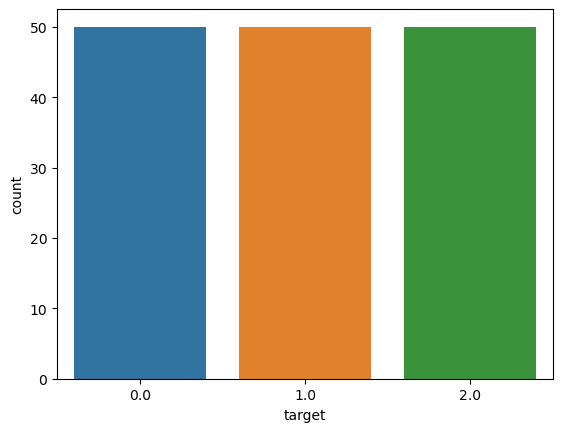

In [5]:
# show distribution of classes
# Equal distribution meaning total 150 
sns.countplot(x='target', data=df)
plt.show()

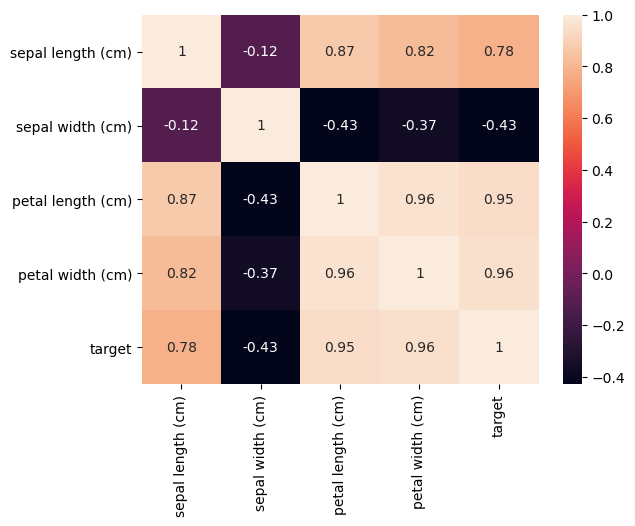

In [6]:
# show correlation matrix
sns.heatmap(df.corr(), annot=True)
plt.show()


In [7]:
# Split the data into training, validation and testing (60% training, 20% validation, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)
# This function was called differently from the other baseline 

In [8]:
# Convert arrays to tensors
X_train = Variable(torch.Tensor(X_train).float())
X_val = Variable(torch.Tensor(X_val).float())
X_test = Variable(torch.Tensor(X_test).float())
y_train = Variable(torch.Tensor(y_train).long())
y_val = Variable(torch.Tensor(y_val).long())
y_test = Variable(torch.Tensor(y_test).long())
# Needs to be updated so that its more streamlined

In [9]:
# PyTorch Datasets
train_dataset = Data.TensorDataset(X_train, y_train)
val_dataset = Data.TensorDataset(X_val, y_val)
test_dataset = Data.TensorDataset(X_test, y_test)

# PyTorch Dataloaders
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = Data.DataLoader(dataset=val_dataset, batch_size=16, shuffle=True)
test_loader = Data.DataLoader(dataset=test_dataset, shuffle=False)

In [10]:
# Define a simpler model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 3)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:

# First instantiate the model
model = Net()

# Now pass the model's parameters to the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01) # L2 regularization

# Continue with your scheduler and loss function
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  
loss_func = torch.nn.CrossEntropyLoss()

In [15]:
def train_model(epochs, train_loader, val_loader, model, device, optimizer, scheduler, criterion):
    for epoch in range(epochs):
        model.train()  # set model to training mode
        running_loss = 0
        n_correct = 0
        total_samples = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for batch in pbar:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            _, predicted = torch.max(outputs, 1)
            n_correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            total_samples += labels.size(0)

            # Update progress bar
            train_acc = 100. * n_correct / total_samples
            pbar.set_postfix({"Train Loss": running_loss / len(pbar), "Train Acc": train_acc})

        model.eval()  # set model to evaluation mode
        n_val_correct = 0
        val_loss = 0
        val_pbar = tqdm(val_loader, desc="Validation")
        with torch.no_grad():
            for batch in val_pbar:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                n_val_correct += (predicted == labels).sum().item()

                val_acc = 100. * n_val_correct / len(val_loader.dataset)

                # Update validation progress bar
                val_pbar.set_postfix({"Val Loss": val_loss / len(val_pbar), "Val Acc": val_acc})


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU for training if available
train_model(25, train_loader, val_loader, model.to(device), device, optimizer, scheduler, loss_func)

Validation: 100%|██████████| 2/2 [00:00<00:00, 348.78it/s, Val Loss=0.752, Val Acc=73.3]


In [16]:
# Testing the network
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing"):
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test set: %d %%' % (100 * correct / total))


Testing: 100%|██████████| 30/30 [00:00<00:00, 3517.53it/s]

Accuracy of the network on the test set: 60 %


/Users/taylorlucero/opt/anaconda3/lib/python3.8/site-packages/mlxtend/plotting/decision_regions.py:315: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)


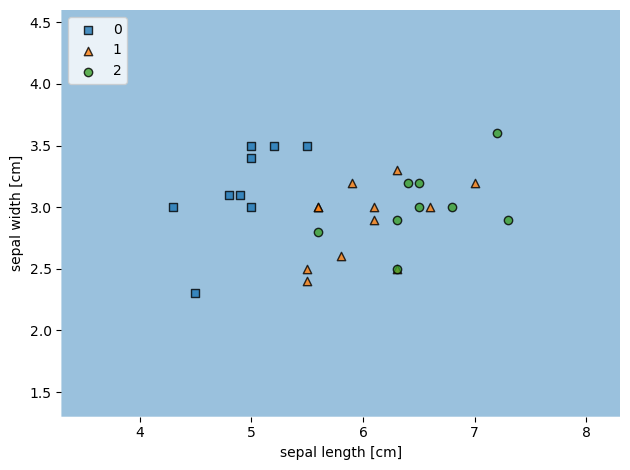

In [21]:
# Choose the indices of the features you want to use
feature_idx1 = 0  # Sepal Length
feature_idx2 = 1  # Sepal Width

# Extract only those features from the test set
X_test_np_sub = X_test_np[:, [feature_idx1, feature_idx2]]

# Define a new model class that only uses those features
class SklearnHelperModelSubset():
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        # Insert dummy values for the other features
        X_full = np.zeros((X.shape[0], 4))
        X_full[:, feature_idx1] = X[:, 0]
        X_full[:, feature_idx2] = X[:, 1]

        # Convert input to Tensor
        X_tensor = torch.from_numpy(X_full).float()
        X_tensor = X_tensor.to(device)

        # Get the model output
        output = self.model(X_tensor)

        # Convert output to numpy and return
        _, y_predicted = torch.max(output.data, 1)
        return y_predicted.cpu().numpy()

# Wrapping your PyTorch model with the helper
model_sklearn_subset = SklearnHelperModelSubset(model)

# Plot the decision boundaries
plot_decision_regions(X_test_np_sub, y_test_np, clf=model_sklearn_subset)
plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
#Application of PCa or only applying two features
# feature selection

In [ ]:

#how would the decision boundaries be plotted with more features?
# is this with both prediction labels and activation functions?